# **Анализ потребительского поведения для ритейлера**

## Над кейсом работали:
 *Кудашов Юрий Михайлович*

 *Оганов Алексей Олегович*

 *Калмыкова Мария Алексеевна*

 *Камышева Ольга Сергеевна*


## РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# настройки отображения
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8')  # используем актуальный стиль
sns.set_theme(palette="husl", style="whitegrid")
%matplotlib inline

# загрузка данных
try:
    df = pd.read_csv('online_retail.csv', encoding='latin1', parse_dates=['InvoiceDate'])
    print(" ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ ")
except FileNotFoundError:
    print("ОШИБКА: Файл 'online_retail.csv' не найден.")
    print("Убедитесь, что файл находится в текущей директории или укажите полный путь.")
    raise

# предобработка
print("\n ИСХОДНЫЕ ДАННЫЕ ")
print(f"Всего записей: {len(df):,}")
print(f"Период данных: с {df['InvoiceDate'].min().date()} по {df['InvoiceDate'].max().date()}")

 ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ 

 ИСХОДНЫЕ ДАННЫЕ 
Всего записей: 502,983
Период данных: с 2010-12-01 по 2011-11-27


#### Очистка данных

In [2]:
df['IsReturn'] = df['InvoiceNo'].astype(str).str.startswith('C')
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# Покупки (без возвратов, положительное кол-во, цена > 0)
purchases = df[(~df['IsReturn']) & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()
returns = df[df['IsReturn']].copy()

print("\n ОЧИЩЕННЫЕ ДАННЫЕ ")
print(f"Покупок: {len(purchases):,} ({len(purchases)/len(df):.1%})")
print(f"Возвратов: {len(returns):,} ({len(returns)/len(df):.1%})")

# Фильтрация по 99-му перцентилю Quantity
q99 = purchases['Quantity'].quantile(0.99)
purchases = purchases[purchases['Quantity'] <= q99]

print(f"Фильтрация по 99-му перцентилю: Quantity ≤ {int(q99)}")
print(f"Покупок после фильтрации: {len(purchases):,}")


 ОЧИЩЕННЫЕ ДАННЫЕ 
Покупок: 491,746 (97.8%)
Возвратов: 8,800 (1.7%)
Фильтрация по 99-му перцентилю: Quantity ≤ 100
Покупок после фильтрации: 487,133



 АНАЛИЗ QUANTITY 


,Показатель,Значение
0,Количество,487133.00
1,Среднее,8.01
2,Ст. отклонение,12.64
3,Минимум,1.00
4,25-й перцентиль,1.00
5,Медиана,3.00
6,75-й перцентиль,10.00
7,95-й перцентиль,25.00
8,99-й перцентиль,72.00
9,Максимум,100.00



 АНАЛИЗ UNITPRICE 


,Показатель,Значение
0,Количество,487133.00
1,Среднее,3.92
2,Ст. отклонение,36.36
3,Минимум,0.00
4,25-й перцентиль,1.25
5,Медиана,2.10
6,75-й перцентиль,4.13
7,95-й перцентиль,9.95
8,99-й перцентиль,16.98
9,Максимум,13541.33



 АНАЛИЗ TOTALSUM 


,Показатель,Значение
0,Количество,487133.00
1,Среднее,16.70
2,Ст. отклонение,72.39
3,Минимум,0.00
4,25-й перцентиль,3.90
5,Медиана,9.90
6,75-й перцентиль,17.40
7,95-й перцентиль,50.74
8,99-й перцентиль,151.16
9,Максимум,38970.00


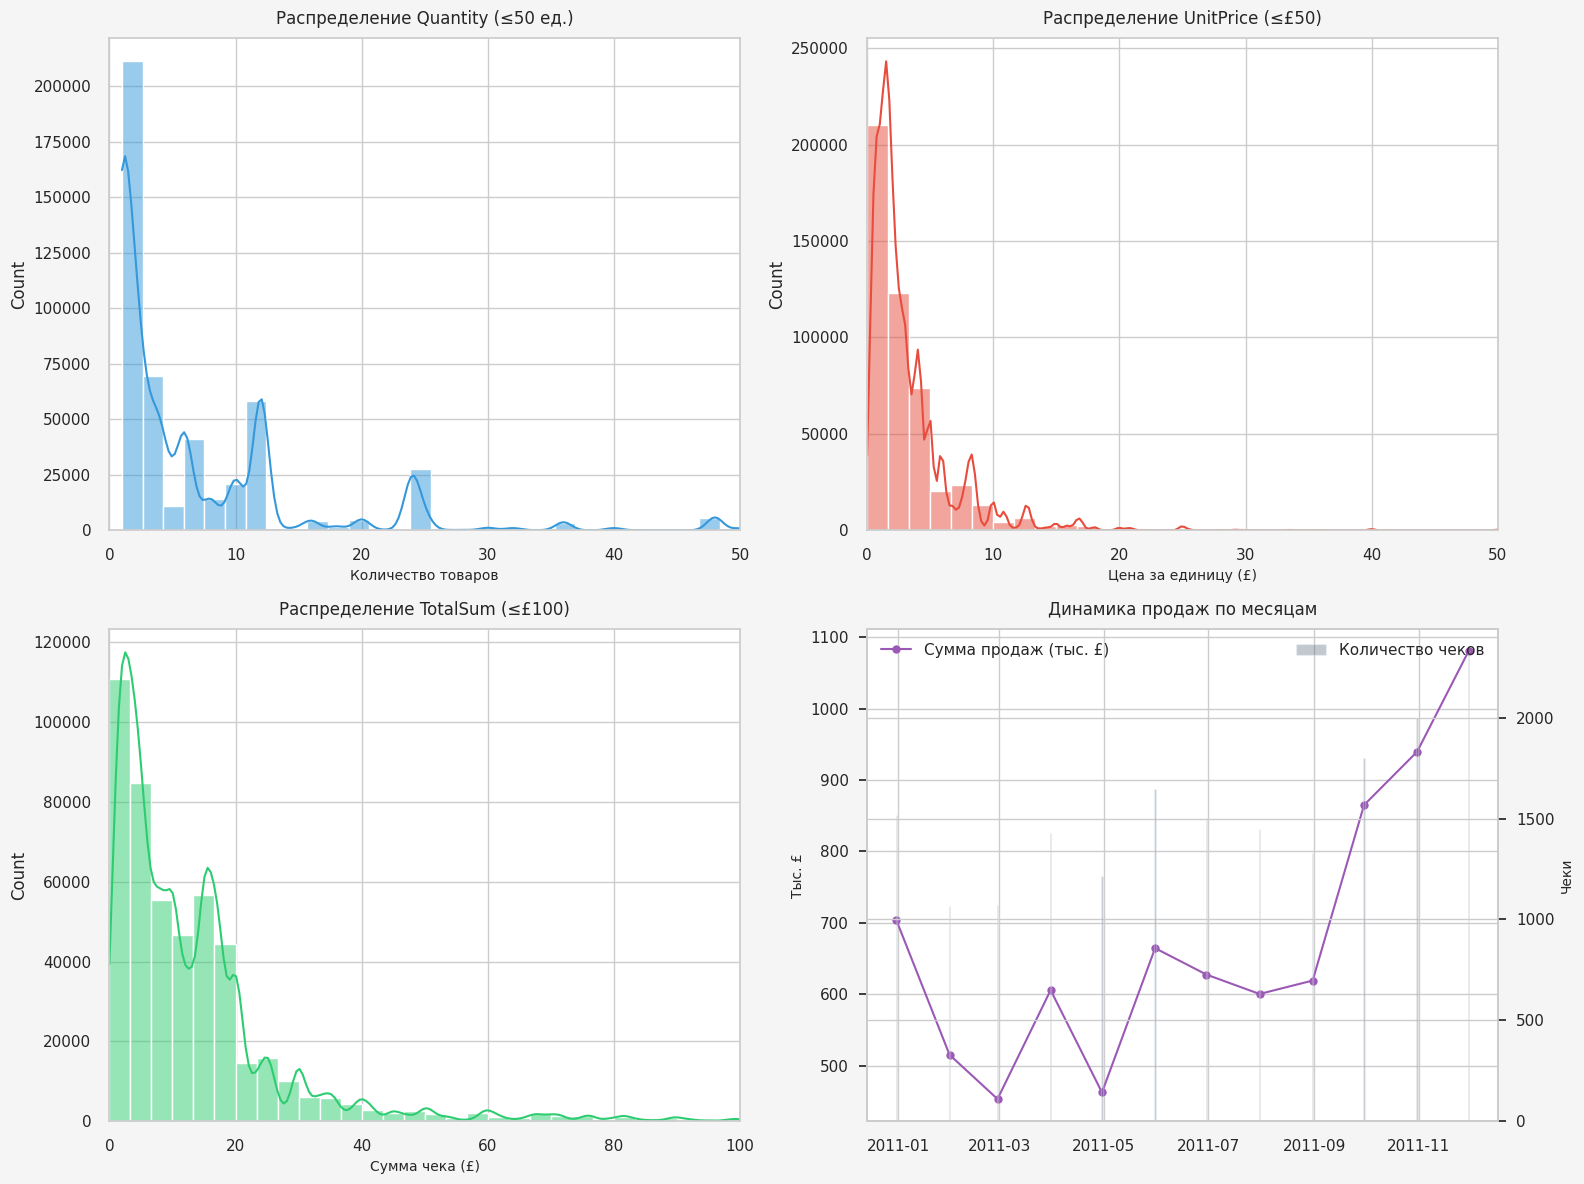


 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА 
Уникальных клиентов: 4,230
Уникальных товаров: 3,908
Средний чек: £16.70
Медианный чек: £9.90

ТОП-5 ТОВАРОВ ПО КОЛИЧЕСТВУ ПРОДАЖ:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2187
JUMBO BAG RED RETROSPOT               1960
REGENCY CAKESTAND 3 TIER              1911
PARTY BUNTING                         1653
LUNCH BAG RED RETROSPOT               1522

ТОП-5 СТРАН ПО ОБЪЕМУ ПРОДАЖ:
Country
United Kingdom    445720
Germany             8536
France              7819
EIRE                7162
Spain               2369


In [6]:
# функция для русскоязычной статистики
def describe_rus(series, name):
    stats = series.describe(percentiles=[.25, .5, .75, .95, .99])
    stats_df = pd.DataFrame({
        'Показатель': ['Количество', 'Среднее', 'Ст. отклонение', 'Минимум',
                      '25-й перцентиль', 'Медиана', '75-й перцентиль',
                      '95-й перцентиль', '99-й перцентиль', 'Максимум',
                      'Асимметрия', 'Эксцесс'],
        'Значение': [stats['count'], stats['mean'], stats['std'], stats['min'],
                    stats['25%'], stats['50%'], stats['75%'], stats['95%'],
                    stats['99%'], stats['max'], series.skew(), series.kurtosis()]
    })
    print(f"\n АНАЛИЗ {name} ")
    return stats_df.round(2)

# статистики
display(describe_rus(purchases['Quantity'], 'QUANTITY'))
display(describe_rus(purchases['UnitPrice'], 'UNITPRICE'))
display(describe_rus(purchases['TotalSum'], 'TOTALSUM'))

# визуализации
fig, ax = plt.subplots(2, 2, figsize=(16, 12), facecolor='#f5f5f5')

# цветовая схема
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

# 1 Quantity
sns.histplot(purchases[purchases['Quantity'] <= 50]['Quantity'],
             bins=30, kde=True, color=colors[0], ax=ax[0,0])
ax[0,0].set_title('Распределение Quantity (≤50 ед.)', pad=10, fontsize=12)
ax[0,0].set_xlabel('Количество товаров', fontsize=10)
ax[0,0].set_xlim(0, 50)

# 2 UnitPrice
sns.histplot(purchases[purchases['UnitPrice'] <= 50]['UnitPrice'],
             bins=30, kde=True, color=colors[1], ax=ax[0,1])
ax[0,1].set_title('Распределение UnitPrice (≤£50)', pad=10, fontsize=12)
ax[0,1].set_xlabel('Цена за единицу (£)', fontsize=10)
ax[0,1].set_xlim(0, 50)

# 3 TotalSum
sns.histplot(purchases[purchases['TotalSum'] <= 100]['TotalSum'],
             bins=30, kde=True, color=colors[2], ax=ax[1,0])
ax[1,0].set_title('Распределение TotalSum (≤£100)', pad=10, fontsize=12)
ax[1,0].set_xlabel('Сумма чека (£)', fontsize=10)
ax[1,0].set_xlim(0, 100)

# 4 временной тренд
monthly = purchases.resample('ME', on='InvoiceDate').agg({
    'TotalSum': 'sum',
    'InvoiceNo': 'nunique'
})
ax[1,1].plot(monthly.index, monthly['TotalSum']/1000, marker='o',
            color=colors[3], label='Сумма продаж (тыс. £)')
ax[1,1].set_title('Динамика продаж по месяцам', pad=10, fontsize=12)
ax[1,1].set_ylabel('Тыс. £', fontsize=10)
ax2 = ax[1,1].twinx()
ax2.bar(monthly.index, monthly['InvoiceNo'], alpha=0.3,
       color='#34495e', label='Количество чеков')
ax2.set_ylabel('Чеки', fontsize=10)
ax[1,1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# дополнительный анализ
print("\n ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ")
print(f"Уникальных клиентов: {purchases['CustomerID'].nunique():,}")
print(f"Уникальных товаров: {purchases['StockCode'].nunique():,}")
print(f"Средний чек: £{purchases['TotalSum'].mean():.2f}")
print(f"Медианный чек: £{purchases['TotalSum'].median():.2f}")

# топ-5 товаров
top_products = purchases['Description'].value_counts().head(5)
print("\nТОП-5 ТОВАРОВ ПО КОЛИЧЕСТВУ ПРОДАЖ:")
print(top_products.to_string())

# топ-5 стран
top_countries = purchases['Country'].value_counts().head(5)
print("\nТОП-5 СТРАН ПО ОБЪЕМУ ПРОДАЖ:")
print(top_countries.to_string())

#### Доля UK и других стран в продажах

На диаграмме видно, что 85% всех продаж приходится на клиентов из Великобритании, и только 15% — на остальные страны.

Это подчёркивает доминирование внутреннего рынка для данного ритейлера и сравнительно небольшую долю международных продаж.

> **Вывод:**  
> Основной фокус бизнеса — британские покупатели. Для дальнейшего роста можно рассмотреть стратегии расширения на зарубежные рынки или повышения активности существующих иностранных клиентов.


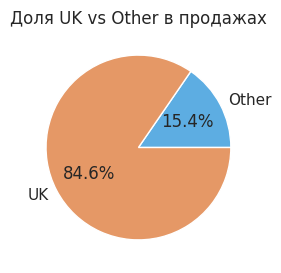

In [7]:
# Агрегация по странам
country_sales = purchases.groupby('Country').agg({
    'InvoiceNo': 'nunique',
    'TotalSum': 'sum'
}).sort_values('TotalSum', ascending=False)

# UK vs Other (10 топ + остальное)
country_sales['CountryType'] = np.where(country_sales.index == 'United Kingdom', 'UK', 'Other')
summary = country_sales.groupby('CountryType').agg({'TotalSum': 'sum', 'InvoiceNo': 'sum'}).reset_index()

# display(country_sales.head(10))
# display(summary)

# # Визуализация продаж по странам
# plt.figure(figsize=(10, 4))

# sns.barplot(data=country_sales.head(10).reset_index(), x='Country', y='TotalSum', palette='pastel')
# plt.title('Топ-10 стран по объёму продаж')
# plt.ylabel('Общая сумма продаж (£)')
# plt.xlabel('Страна')
# plt.xticks(rotation=30)
# plt.tight_layout()
# plt.show()

# UK vs Other — доля
plt.figure(figsize=(5, 3))
plt.pie(summary['TotalSum'], labels=summary['CountryType'], autopct='%1.1f%%', colors=['#5dade2', '#e59866'])
plt.title('Доля UK vs Other в продажах')
plt.show()


#### Сезонность продаж по месяцам

На графике заметно выраженная сезонность: объём продаж стабильно увеличивается во второй половине года и достигает максимума в ноябре–декабре. Такой рост может быть связан с предпраздничными распродажами и подготовкой к рождественскому периоду.

> **Вывод:**  
> Для максимизации выручки важно заранее готовиться к пиковым нагрузкам в конце года, а также использовать маркетинговые активности, стимулирующие продажи в "низкий" сезон.


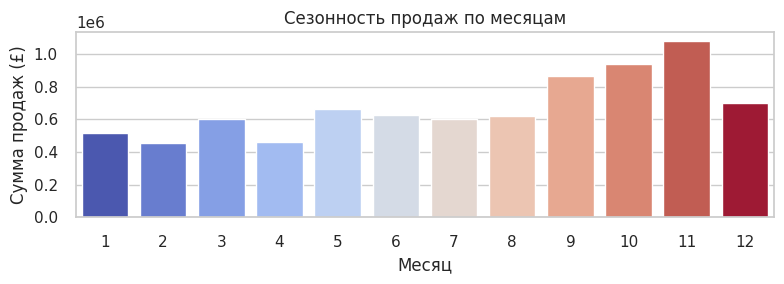

In [9]:
# Сезонность по месяцам
purchases['MonthNum'] = purchases['InvoiceDate'].dt.month
monthly_trend = purchases.groupby('MonthNum')['TotalSum'].sum()

plt.figure(figsize=(8, 3))
sns.barplot(x=monthly_trend.index, y=monthly_trend.values, palette='coolwarm', hue=monthly_trend.index, legend=False )
plt.title('Сезонность продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж (£)')
plt.tight_layout()
plt.show()

#### Сезонность продаж по дням недели

Большая часть продаж приходится на вторник, среду и четверг, а минимальный объём — на воскресенье. В субботу продаж нет, что связано с отсутствием данных за этот день недели в исходном датасете.

> **Вывод:**  
> Основной поток покупателей приходится на рабочие дни, что типично для B2B или оптовых клиентов. Рекомендуется использовать промоакции для увеличения продаж в выходные или проанализировать причины низкой активности в эти дни.


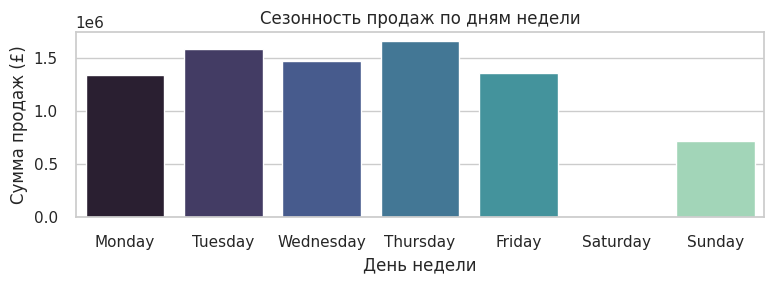

In [14]:
# Сезонность по дням недели
purchases['Weekday'] = purchases['InvoiceDate'].dt.day_name()
weekday_trend = purchases.groupby('Weekday')['TotalSum'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(8, 3))
sns.barplot(x=weekday_trend.index, y=weekday_trend.values, palette='mako', hue=weekday_trend.index, legend=False)
plt.title('Сезонность продаж по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма продаж (£)')
plt.tight_layout()
plt.show()

В исходных данных отсутствуют транзакции по субботам за весь анализируемый период. Это может быть связано с особенностями бизнеса. Данный факт следует учесть при интерпретации сезонности по дням недели.

#### Распределение продаж по часам суток

Наиболее активно покупки совершаются с 10 до 15 часов, после чего продажи резко падают. Минимум активности — в вечерние и ранние утренние часы.

> **Вывод:**  
> Основное время покупок — рабочий день. Это важно учитывать при планировании акций, логистики и поддержки клиентов.


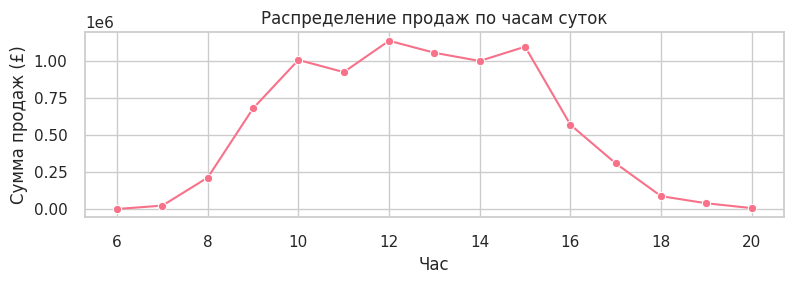

In [15]:
# Сезонность по часам
purchases['Hour'] = purchases['InvoiceDate'].dt.hour
hourly_trend = purchases.groupby('Hour')['TotalSum'].sum()

plt.figure(figsize=(8, 3))
sns.lineplot(x=hourly_trend.index, y=hourly_trend.values, marker='o')
plt.title('Распределение продаж по часам суток')
plt.xlabel('Час')
plt.ylabel('Сумма продаж (£)')
plt.tight_layout()
plt.show()

#### Связь между объёмом продаж и возвратами

На диаграмме показана корреляция между суммой продаж по месяцам и долей возвратов.

Наблюдается слабая отрицательная связь: при увеличении объёма продаж процент возвратов снижается. Это может говорить о том, что в периоды высоких продаж компания либо более тщательно следит за качеством товаров, либо активнее проводит промо-акции, что снижает возвратность.

> **Вывод:**  
> Рекомендуется обратить внимание на периоды с высокой возвратностью и проанализировать причины, чтобы снизить потери и повысить удовлетворённость клиентов.


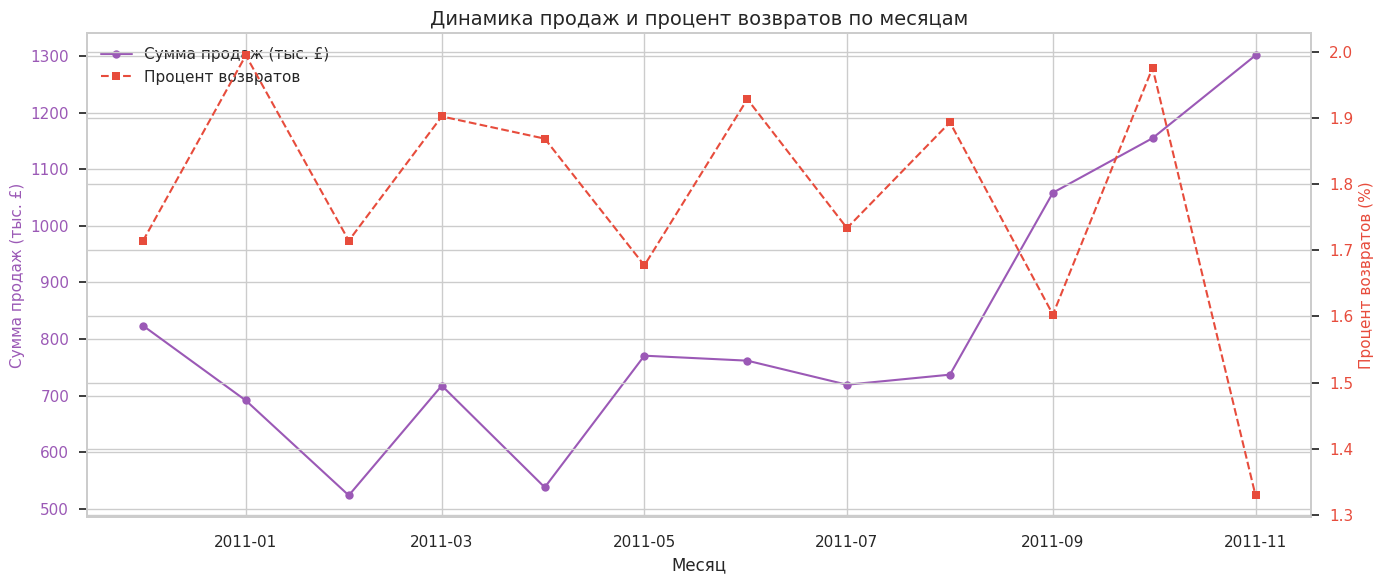

In [16]:
# перерасчёт для объединённой визуализации
df['Month'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
monthly_summary = df.groupby('Month').agg(
    TotalSales=('TotalSum', lambda x: x[~df.loc[x.index, 'IsReturn']].sum()),
    Purchases=('IsReturn', lambda x: (~x).sum()),
    Returns=('IsReturn', lambda x: x.sum())
)
monthly_summary['ReturnRate'] = monthly_summary['Returns'] / (monthly_summary['Purchases'] + monthly_summary['Returns']) * 100

# визуализация
fig, ax1 = plt.subplots(figsize=(14, 6))
color_sales = '#9b59b6'
color_returns = '#e74c3c'

# Линия: продажи
ax1.plot(monthly_summary.index, monthly_summary['TotalSales'] / 1000, marker='o', color=color_sales, label='Сумма продаж (тыс. £)')
ax1.set_ylabel('Сумма продаж (тыс. £)', color=color_sales, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color_sales)
ax1.set_xlabel('Месяц')
ax1.set_title('Динамика продаж и процент возвратов по месяцам', fontsize=14)
ax1.grid(True)

# Вторая ось Y: процент возвратов
ax2 = ax1.twinx()
ax2.plot(monthly_summary.index, monthly_summary['ReturnRate'], marker='s', color=color_returns, linestyle='--', label='Процент возвратов')
ax2.set_ylabel('Процент возвратов (%)', color=color_returns, fontsize=11)
ax2.tick_params(axis='y', labelcolor=color_returns)

# Объединённая легенда
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# корреляция между суммой продаж и процентом возвратов
correlation = monthly_summary['TotalSales'].corr(monthly_summary['ReturnRate'])
print(f"Корреляция между суммой продаж и процентом возвратов: {correlation:.3f}")


Корреляция между суммой продаж и процентом возвратов: -0.500


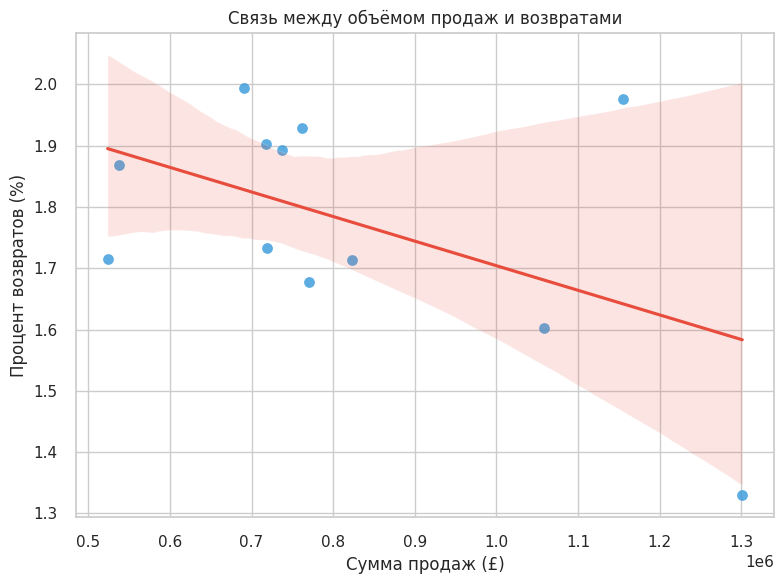

In [18]:
plt.figure(figsize=(8, 6))
sns.regplot(data=monthly_summary, x='TotalSales', y='ReturnRate',
            scatter_kws={'s': 60, 'color': '#3498db'},
            line_kws={'color': '#e74c3c'})
plt.xlabel('Сумма продаж (£)')
plt.ylabel('Процент возвратов (%)')
plt.title('Связь между объёмом продаж и возвратами')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Динамика уникальных покупателей по месяцам

На графике показано, как менялось количество уникальных клиентов (держателей дисконтных карт), совершавших покупки в каждом месяце анализируемого периода.

В течение года наблюдается плавный рост клиентской базы, особенно заметный во второй половине года — с сентября по ноябрь число уникальных покупателей существенно увеличивается и достигает пика в ноябре. Это может быть связано с сезонными распродажами и предпраздничными акциями. В декабре — резкое падение, что, вероятно, связано с неполным покрытием данных за месяц или с завершением отчетного периода.

> **Вывод:**  
> Розничный бизнес привлекает новых клиентов ближе к концу года, вероятно, за счёт праздничных кампаний. Рекомендуется уделять особое внимание удержанию новых клиентов, привлечённых в этот период, чтобы повысить общую лояльность и увеличить повторные продажи в будущем.


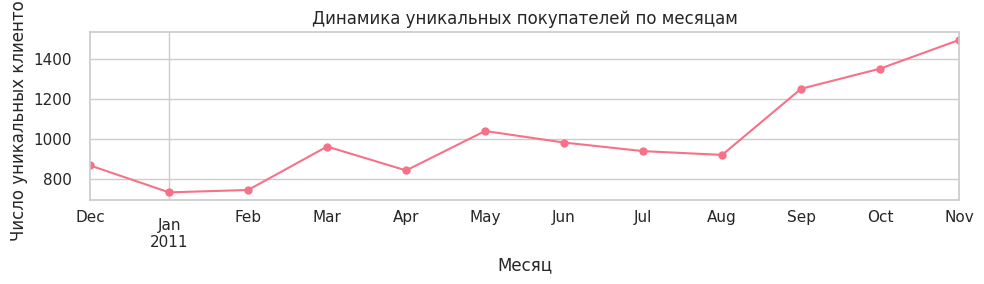

In [19]:
# Новые и старые клиенты по месяцам
purchases['Month'] = purchases['InvoiceDate'].dt.to_period('M')
monthly_customers = purchases.groupby('Month')['CustomerID'].nunique()
plt.figure(figsize=(10,3))
monthly_customers.plot(marker='o')
plt.title('Динамика уникальных покупателей по месяцам')
plt.ylabel('Число уникальных клиентов')
plt.xlabel('Месяц')
plt.tight_layout()
plt.show()


#### Распределение жизненной ценности клиента (CLTV)

**Жизненная ценность клиента** (Customer Lifetime Value, CLTV) — это метрика, используемая для оценки прибыли, которую компания может получить от своего клиента за время его пользования продуктами и сервисами компании.

На графике представлено распределение жизненной ценности клиентов (Customer Lifetime Value, CLTV), то есть совокупной суммы всех покупок, совершённых каждым клиентом за период анализа.

Большинство клиентов принесли компании менее £2000, при этом значительное число покупателей — менее £1000. Длинный "хвост" справа указывает на небольшую группу клиентов с очень высокой жизненной ценностью (до £14 000).

Такое распределение характерно для большинства розничных компаний: основная масса клиентов — с низкой активностью, а основную выручку приносят немногие "ключевые" покупатели.

> **Вывод:**  
> Для роста дохода бизнеса важно удерживать и развивать наиболее ценных клиентов, а также стимулировать повторные покупки среди основной массы покупателей с низким CLTV.


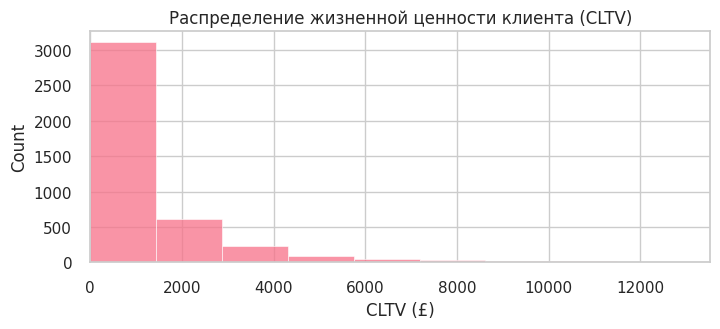

In [20]:
clv = purchases.groupby('CustomerID')['TotalSum'].sum()
plt.figure(figsize=(8,3))
sns.histplot(clv, bins=100)
plt.title('Распределение жизненной ценности клиента (CLTV)')
plt.xlabel('CLTV (£)')
plt.xlim(0, clv.quantile(0.99))
plt.show()


#### Распределение количества товаров в чеке

На гистограмме показано, сколько товаров в среднем содержится в одном чеке.

Большинство чеков включают от 1 до 200 позиций, что указывает на преобладание мелкооптовых или розничных покупок. Однако, наблюдается длинный правый "хвост" — это отдельные случаи больших закупок, что характерно для корпоративных клиентов или редких оптовых сделок.

> **Вывод:**  
> Структура чеков указывает на то, что основная масса покупателей делает небольшие покупки, но часть выручки формируется за счёт крупных заказов, которые стоит анализировать отдельно для понимания их влияния на бизнес.


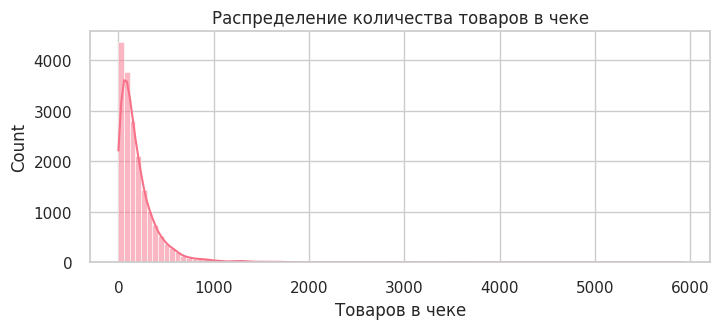

In [21]:
# Количество позиций в чеке
check_items = purchases.groupby('InvoiceNo')['Quantity'].sum()
plt.figure(figsize=(8,3))
sns.histplot(check_items, bins=100, kde=True)
plt.title('Распределение количества товаров в чеке')
plt.xlabel('Товаров в чеке')
plt.show()


## СЕГМЕНТАЦИЯ КЛИЕНТОВ (RFM + КЛАСТЕРИЗАЦИЯ)

#### Подбор оптимального числа кластеров для сегментации клиентов

Для выбора наиболее подходящего количества сегментов проведён анализ методом локтя и по коэффициенту силуэта:

- **Метод локтя** позволяет определить, при каком числе кластеров внутри-групповая сумма квадратов (inertia) перестаёт резко снижаться — это указывает на "оптимальную" точку разбиения.
- **Silhouette Score** показывает качество разделения данных на кластеры (чем выше, тем более чёткие и плотные группы).

Оба графика выше помогают выбрать оптимальное количество сегментов:  
- По методу локтя — оптимум обычно там, где линия начинает выравниваться.
- По коэффициенту силуэта — максимальное значение указывает на наилучшее качество разбиения.

> **Вывод:**  
> Использование обеих метрик позволяет обоснованно выбрать количество клиентских сегментов для дальнейшего анализа.

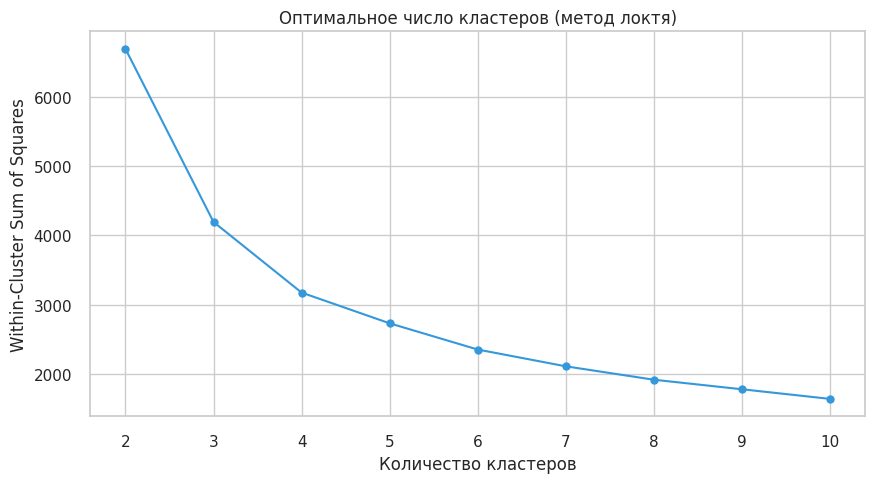

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

snapshot_date = purchases['InvoiceDate'].max()

# переименовываем метрики на русский
rfm = purchases.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # время с последней покупки
    'InvoiceNo': 'nunique',                                  # частота покупок
    'TotalSum': 'sum'                                        # сумма покупок
}).rename(columns={
    'InvoiceDate': 'Время_с_последней_покупки',
    'InvoiceNo': 'Частота_покупок',
    'TotalSum': 'Общая_сумма'
})

# логарифмическое преобразование (кроме времени)
rfm_log = rfm.apply(lambda x: np.log1p(x) if x.name != 'Время_с_последней_покупки' else x)

# стандартизация
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# подбор числа кластеров
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o', color='#3498db')
plt.title('Оптимальное число кластеров (метод локтя)')
plt.xlabel('Количество кластеров')
plt.ylabel('Within-Cluster Sum of Squares')
plt.grid(True)
plt.show()

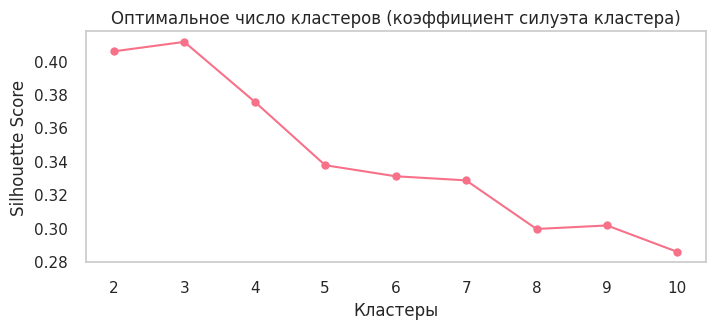

In [23]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    scores.append(score)

plt.figure(figsize=(8,3))
plt.plot(range(2,11), scores, marker='o')
plt.title('Оптимальное число кластеров (коэффициент силуэта кластера)')
plt.xlabel('Кластеры')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


### Кластеризация при K=3

         Время_с_последней_покупки  Частота_покупок  Общая_сумма
Кластер                                                         
0                            50.26             2.00       592.83
1                            30.37             9.38      4135.28
2                           243.61             1.37       365.26


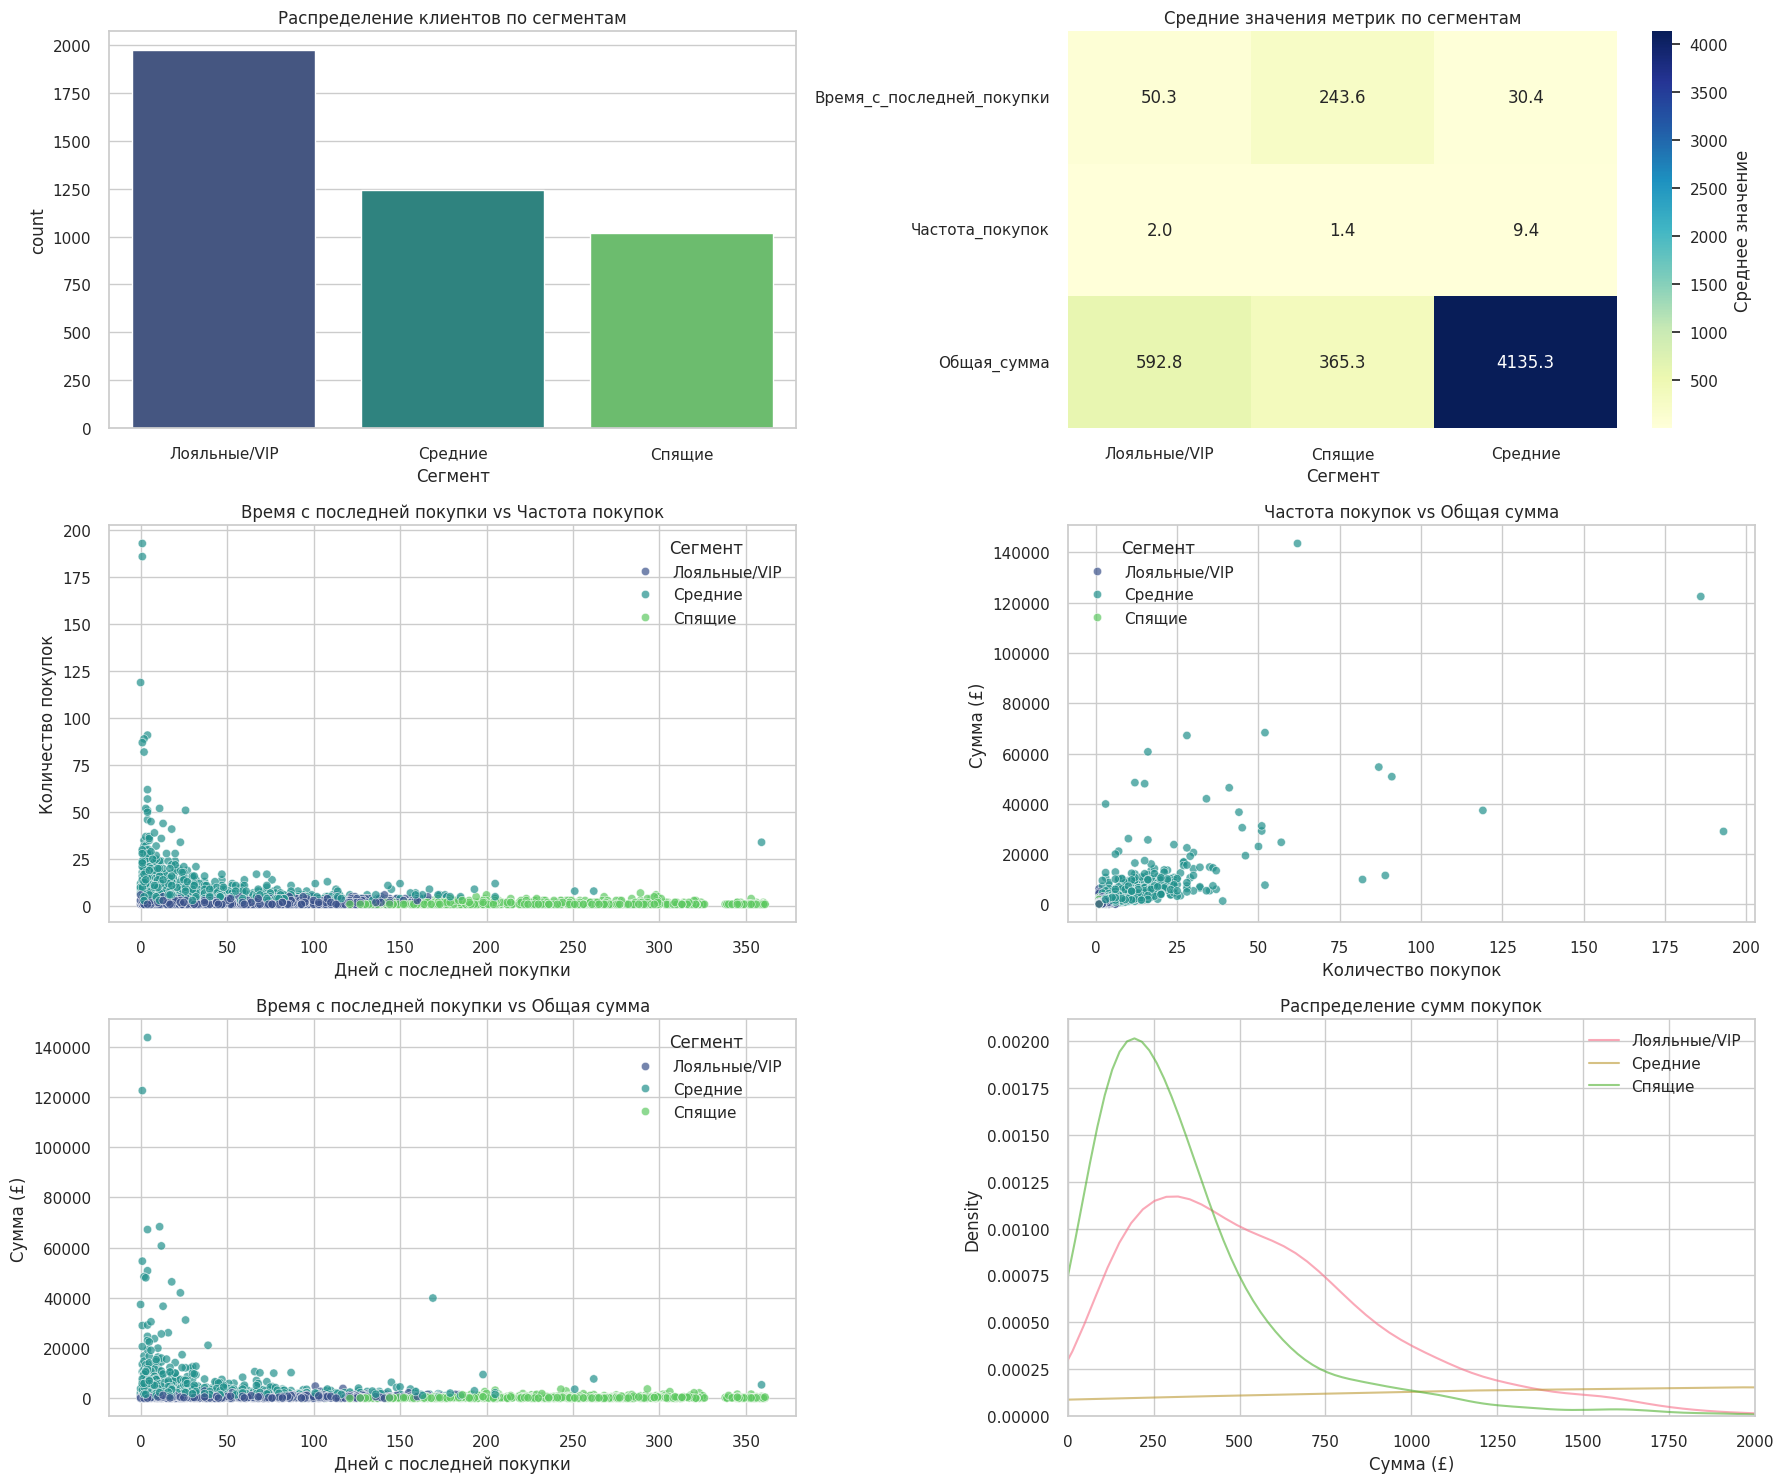

Время_с_последней_покупки        Частота_покупок         \
                                  mean median            mean median   
Сегмент                                                                
Лояльные/VIP                     50.30  40.00            2.00   2.00   
Спящие                          243.60 241.00            1.40   1.00   
Средние                          30.40  17.00            9.40   7.00   

             Общая_сумма                
                    mean  median count  
Сегмент                                 
Лояльные/VIP      592.80  499.60  1972  
Спящие            365.30  265.90  1016  
Средние          4135.30 2380.70  1242

In [26]:
# кластеризация (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Кластер'] = kmeans.fit_predict(rfm_scaled)

profiles = rfm.groupby('Кластер')[['Время_с_последней_покупки', 'Частота_покупок', 'Общая_сумма']].mean()
print(profiles)

# профилирование кластеров
segment_names_3 = {
    0: 'Лояльные/VIP',
    1: 'Средние',
    2: 'Спящие'
}
rfm['Сегмент'] = rfm['Кластер'].map(segment_names_3)

# визуализация
fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 2)

# распределение сегментов
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(data=rfm, x='Сегмент', palette='viridis',
             order=list(segment_names_3.values()), hue='Сегмент', legend=False)
ax1.set_title('Распределение клиентов по сегментам')

# тепловая карта метрик
ax2 = fig.add_subplot(gs[0, 1])
cluster_means = rfm.groupby('Сегмент')[['Время_с_последней_покупки', 'Частота_покупок', 'Общая_сумма']].mean()
sns.heatmap(cluster_means.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Среднее значение'})
ax2.set_title('Средние значения метрик по сегментам')

# время vs частота
ax3 = fig.add_subplot(gs[1, 0])
sns.scatterplot(data=rfm, x='Время_с_последней_покупки', y='Частота_покупок',
               hue='Сегмент', palette='viridis', alpha=0.7)
ax3.set_title('Время с последней покупки vs Частота покупок')
ax3.set_xlabel('Дней с последней покупки')
ax3.set_ylabel('Количество покупок')

# частота vs сумма
ax4 = fig.add_subplot(gs[1, 1])
sns.scatterplot(data=rfm, x='Частота_покупок', y='Общая_сумма',
               hue='Сегмент', palette='viridis', alpha=0.7)
ax4.set_title('Частота покупок vs Общая сумма')
ax4.set_xlabel('Количество покупок')
ax4.set_ylabel('Сумма (£)')

# время vs сумма
ax5 = fig.add_subplot(gs[2, 0])
sns.scatterplot(data=rfm, x='Время_с_последней_покупки', y='Общая_сумма',
               hue='Сегмент', palette='viridis', alpha=0.7)
ax5.set_title('Время с последней покупки vs Общая сумма')
ax5.set_xlabel('Дней с последней покупки')
ax5.set_ylabel('Сумма (£)')

# распределение сумм
ax6 = fig.add_subplot(gs[2, 1])
for segment in segment_names_3.values():
    sns.kdeplot(rfm[rfm['Сегмент'] == segment]['Общая_сумма'],
               label=segment, alpha=0.6)
ax6.set_title('Распределение сумм покупок')
ax6.set_xlabel('Сумма (£)')
ax6.set_xlim(0, 2000)
ax6.legend()

plt.tight_layout()
plt.show()

stats = rfm.groupby('Сегмент').agg({
    'Время_с_последней_покупки': ['mean', 'median'],
    'Частота_покупок': ['mean', 'median'],
    'Общая_сумма': ['mean', 'median', 'count']
}).round(1)

stats

### Кластеризация при K=5

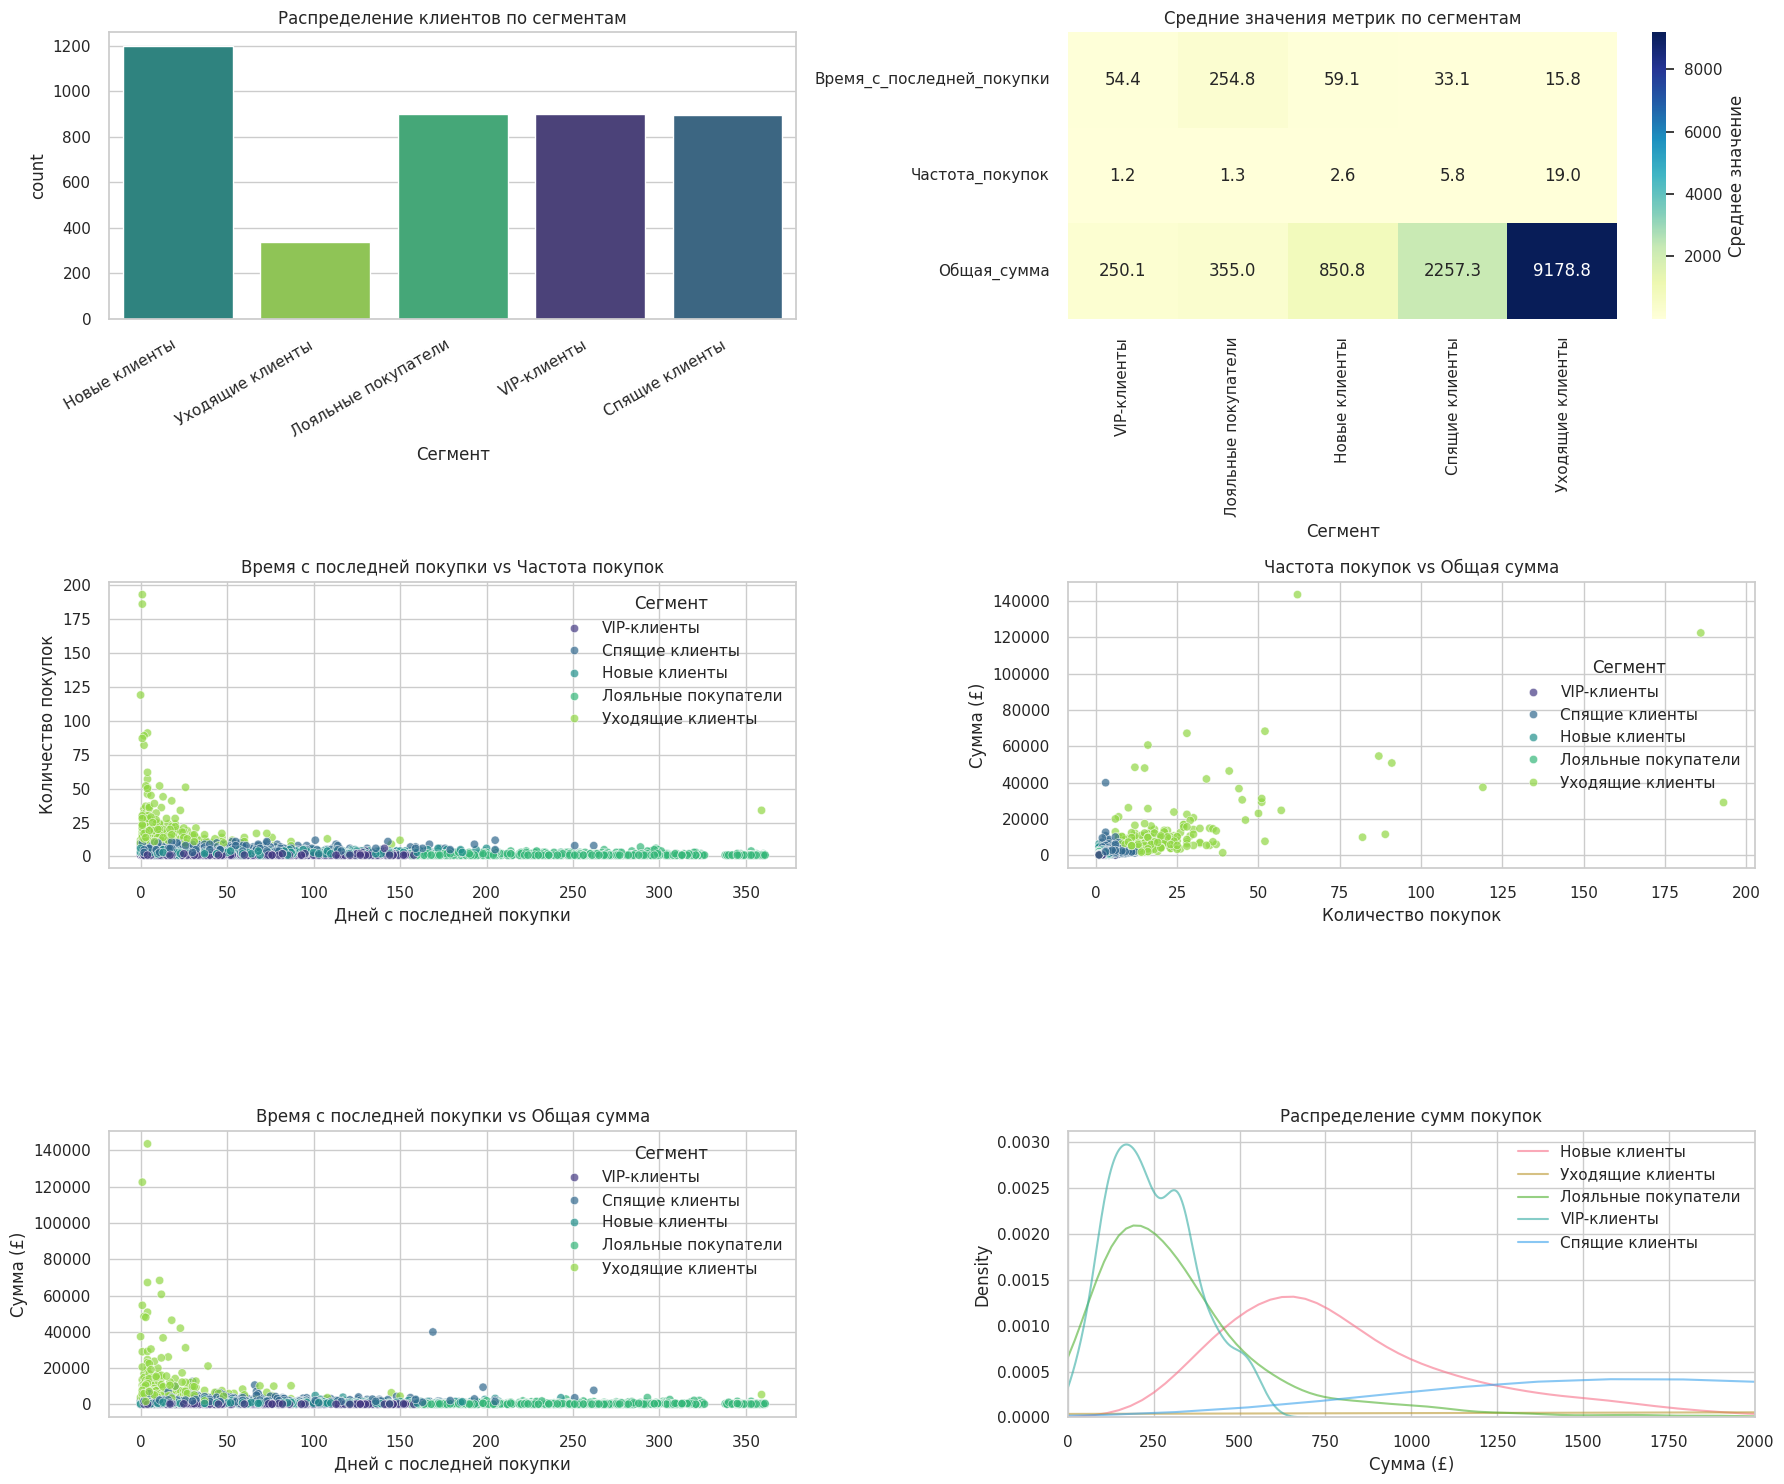

СТАТИСТИКА ПО СЕГМЕНТАМ


Время_с_последней_покупки        Частота_покупок         \
                                         mean median            mean median   
Сегмент                                                                       
VIP-клиенты                             54.40  44.00            1.20   1.00   
Лояльные покупатели                    254.80 250.00            1.30   1.00   
Новые клиенты                           59.10  45.00            2.60   2.00   
Спящие клиенты                          33.10  20.00            5.80   5.00   
Уходящие клиенты                        15.80   9.00           19.00  14.00   

                    Общая_сумма                
                           mean  median count  
Сегмент                                        
VIP-клиенты              250.10  233.20   898  
Лояльные покупатели      355.00  270.90   902  
Новые клиенты            850.80  728.70  1199  
Спящие клиенты          2257.30 1921.00   894  
Уходящие клиенты        9178.80 5512.90   337

In [32]:
# кластеризация (K=5)
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Кластер'] = kmeans.fit_predict(rfm_scaled)

# профилирование кластеров
segment_names = {
    0: 'Новые клиенты',
    1: 'Уходящие клиенты',
    2: 'Лояльные покупатели',
    3: 'VIP-клиенты',
    4: 'Спящие клиенты'
}
rfm['Сегмент'] = rfm['Кластер'].map(segment_names)

# визуализация
fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 2)

# распределение сегментов
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(data=rfm, x='Сегмент', palette='viridis',
             order=list(segment_names.values()), hue='Сегмент', legend=False)


ax1.set_title('Распределение клиентов по сегментам')
plt.tight_layout()
fig.autofmt_xdate()

# тепловая карта метрик
ax2 = fig.add_subplot(gs[0, 1])
cluster_means = rfm.groupby('Сегмент')[['Время_с_последней_покупки', 'Частота_покупок', 'Общая_сумма']].mean()
sns.heatmap(cluster_means.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Среднее значение'})
ax2.set_title('Средние значения метрик по сегментам')

# время vs частота
ax3 = fig.add_subplot(gs[1, 0])
sns.scatterplot(data=rfm, x='Время_с_последней_покупки', y='Частота_покупок',
               hue='Сегмент', palette='viridis', alpha=0.7)
ax3.set_title('Время с последней покупки vs Частота покупок')
ax3.set_xlabel('Дней с последней покупки')
ax3.set_ylabel('Количество покупок')

# частота vs сумма
ax4 = fig.add_subplot(gs[1, 1])
sns.scatterplot(data=rfm, x='Частота_покупок', y='Общая_сумма',
               hue='Сегмент', palette='viridis', alpha=0.7)
ax4.set_title('Частота покупок vs Общая сумма')
ax4.set_xlabel('Количество покупок')
ax4.set_ylabel('Сумма (£)')

# время vs сумма
ax5 = fig.add_subplot(gs[2, 0])
sns.scatterplot(data=rfm, x='Время_с_последней_покупки', y='Общая_сумма',
               hue='Сегмент', palette='viridis', alpha=0.7)
ax5.set_title('Время с последней покупки vs Общая сумма')
ax5.set_xlabel('Дней с последней покупки')
ax5.set_ylabel('Сумма (£)')

# распределение сумм
ax6 = fig.add_subplot(gs[2, 1])
for segment in segment_names.values():
    sns.kdeplot(rfm[rfm['Сегмент'] == segment]['Общая_сумма'],
               label=segment, alpha=0.6)
ax6.set_title('Распределение сумм покупок')
ax6.set_xlabel('Сумма (£)')
ax6.set_xlim(0, 2000)
ax6.legend()

plt.tight_layout()
plt.show()

# статистика по кластерам
print("СТАТИСТИКА ПО СЕГМЕНТАМ")
stats = rfm.groupby('Сегмент').agg({
    'Время_с_последней_покупки': ['mean', 'median'],
    'Частота_покупок': ['mean', 'median'],
    'Общая_сумма': ['mean', 'median', 'count']
}).round(1)
display(stats)

### Вывод по сравнению сегментаций (3 vs 5 кластеров)

Сравнение кластеризаций с использованием Silhouette Score показывает, что качество разбиения на 3 сегмента немного выше (0.337 против 0.299 для 5 кластеров), однако разница между вариантами невелика.

Учитывая задачи бизнес-аналитики и маркетинга, целесообразно использовать сегментацию на **5 кластеров** — это позволяет получить более детализированную картину клиентской базы и точнее таргетировать коммуникации, персонализировать предложения и разрабатывать стратегии для каждой специфической группы клиентов.

> **Итого:**  
> При незначительной потере "плотности" сегментов, кластеризация на 5 групп обеспечивает большую ценность для прикладных задач бизнеса, чем более грубое деление на 3 кластера.


In [33]:
# Только числовые признаки
rfm_for_cluster = rfm[['Время_с_последней_покупки', 'Частота_покупок', 'Общая_сумма']].apply(np.log1p)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_cluster)

# Кластеризация для k=3 и k=5
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans5 = KMeans(n_clusters=5, random_state=42)

rfm['Кластер_3'] = kmeans3.fit_predict(rfm_scaled)
rfm['Кластер_5'] = kmeans5.fit_predict(rfm_scaled)

# Silhouette Score
silhouette_3 = silhouette_score(rfm_scaled, rfm['Кластер_3'])
silhouette_5 = silhouette_score(rfm_scaled, rfm['Кластер_5'])
print(f'Silhouette Score для 3 кластеров: {silhouette_3:.3f}')
print(f'Silhouette Score для 5 кластеров: {silhouette_5:.3f}')

Silhouette Score для 3 кластеров: 0.328
Silhouette Score для 5 кластеров: 0.329


## АССОЦИАТИВНЫЕ ПРАВИЛА

Загрузка данных...
Загружено 541909 записей, из них 525255 покупок

Фильтрация данных для ассоциативных правил...


/tmp/ipython-input-34-3460719139.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Description'] = filtered['Description'].str.upper().str.strip()


Для анализа используется 94408 записей из 15232 чеков

Подготовка транзакций...
Матрица создана за 0.3 сек. Размер: (15232, 98)

Поиск частых наборов товаров...
Найдено 144 наборов за 0.0 сек

Генерация ассоциативных правил...


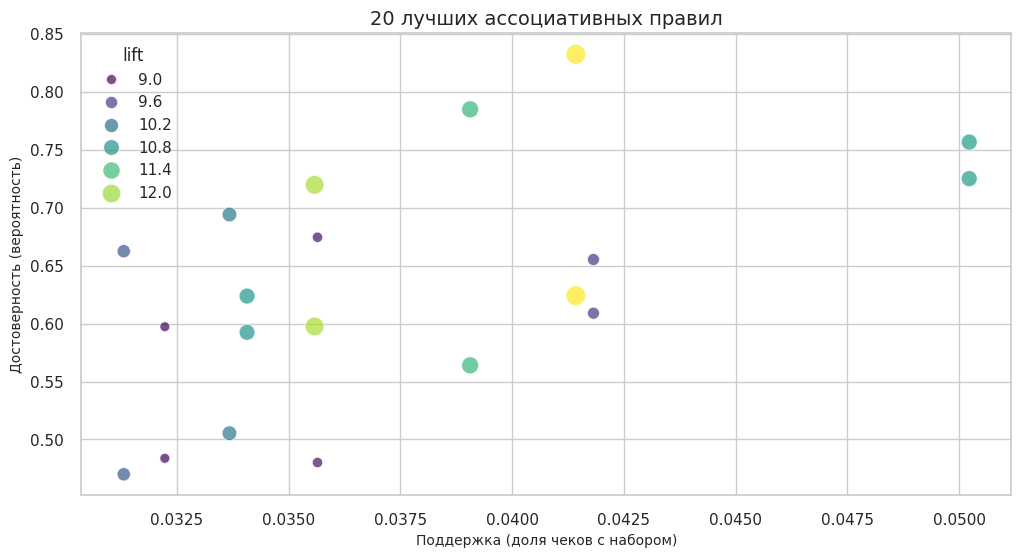

In [34]:
# БЕРЕМ ТОЛЬКО ТОП 100

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

# подготовка данных
print("Загрузка данных...")
try:

    df = pd.read_csv('online_retail.csv', encoding='latin1', parse_dates=['InvoiceDate'])

    # предобработка данных
    df['TotalSum'] = df['Quantity'] * df['UnitPrice']
    df['IsReturn'] = df['InvoiceNo'].astype(str).str.startswith('C')
    purchases = df[(~df['IsReturn']) & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

    q99 = purchases['Quantity'].quantile(0.99)
    purchases = purchases[purchases['Quantity'] <= q99] # добавлена фильтрация

    print(f"Загружено {len(df)} записей, из них {len(purchases)} покупок")
except Exception as e:
    print(f"Ошибка при загрузке данных: {str(e)}")
    raise

# фильтрация данных
print("\nФильтрация данных для ассоциативных правил...")

# берем только чеки с 2+ товарами
multi_item = purchases.groupby('InvoiceNo')['StockCode'].count()
multi_item = multi_item[multi_item >= 2].index
filtered = purchases[purchases['InvoiceNo'].isin(multi_item)]

# берем топ-100 самых популярных товаров (для скорости)
top_products = filtered['Description'].value_counts().head(100).index
filtered = filtered[filtered['Description'].isin(top_products)]

filtered['Description'] = filtered['Description'].str.upper().str.strip()
filtered = filtered[~filtered['Description'].str.contains('POSTAGE|MANUAL|SAMPLE')]


print(f"Для анализа используется {len(filtered)} записей из {filtered['InvoiceNo'].nunique()} чеков")

# подготовка транзакций
print("\nПодготовка транзакций...")
start_time = time.time()

transactions = filtered.groupby('InvoiceNo')['Description'].apply(list).values.tolist()

# создаем бинарную матрицу
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Матрица создана за {time.time()-start_time:.1f} сек. Размер: {basket_df.shape}")

# поиск частых наборов
print("\nПоиск частых наборов товаров...")
start_time = time.time()

frequent_itemsets = apriori(
    basket_df,
    min_support=0.03,  # поддержка 3%
    use_colnames=True,
    max_len=2,         # анализируем только пары
    low_memory=True    # режим экономии памяти
)

print(f"Найдено {len(frequent_itemsets)} наборов за {time.time()-start_time:.1f} сек")

# генерация правил
print("\nГенерация ассоциативных правил...")
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.5  # минимальная сила связи
)

# фильтрация и сортировка
strong_rules = rules[
    (rules['confidence'] > 0.4) &
    (rules['lift'] > 2)
].sort_values('lift', ascending=False)

# визуализация
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=strong_rules.head(20),
    x='support',
    y='confidence',
    size='lift',
    hue='lift',
    palette='viridis',
    sizes=(50, 200),
    alpha=0.7
)
plt.title('20 лучших ассоциативных правил', fontsize=14)
plt.xlabel('Поддержка (доля чеков с набором)', fontsize=10)
plt.ylabel('Достоверность (вероятность)', fontsize=10)
plt.grid(True)
plt.show()

In [35]:
# Оставляем только уникальные пары (A+B = B+A)
def frozen_set_to_sorted_tuple(fs):
    return tuple(sorted(list(fs)))

strong_rules['pair'] = strong_rules.apply(
    lambda row: frozen_set_to_sorted_tuple(row['antecedents'] | row['consequents']),
    axis=1
)

# Убираем дубликаты по уникальной паре
strong_rules_nodup = strong_rules.drop_duplicates('pair').copy()

# Можно сразу сортировать, если нужно
strong_rules_nodup = strong_rules_nodup.sort_values('lift', ascending=False)

if not strong_rules_nodup.empty:
    print("\nТОП-20 АССОЦИАТИВНЫХ ПРАВИЛ (уникальные пары):")
    for i, rule in strong_rules_nodup.head(20).iterrows():
        print(f"\nПРАВИЛО {i+1}:")
        print(f"Если покупают {list(rule['antecedents'])[0]},")
        print(f"то с вероятностью {rule['confidence']:.1%} купят также {list(rule['consequents'])[0]}")
        print(f"Сила связи (lift): {rule['lift']:.1f}")
        print(f"Поддержка: {rule['support']:.2%} чеков содержат этот набор")
else:
    print("Не найдено значимых уникальных ассоциативных правил")


ТОП-20 АССОЦИАТИВНЫХ ПРАВИЛ (уникальные пары):

ПРАВИЛО 14:
Если покупают PINK REGENCY TEACUP AND SAUCER,
то с вероятностью 83.2% купят также GREEN REGENCY TEACUP AND SAUCER
Сила связи (lift): 12.5
Поддержка: 4.14% чеков содержат этот набор

ПРАВИЛО 12:
Если покупают GARDENERS KNEELING PAD CUP OF TEA,
то с вероятностью 72.0% купят также GARDENERS KNEELING PAD KEEP CALM
Сила связи (lift): 12.1
Поддержка: 3.56% чеков содержат этот набор

ПРАВИЛО 82:
Если покупают PINK REGENCY TEACUP AND SAUCER,
то с вероятностью 78.5% купят также ROSES REGENCY TEACUP AND SAUCER
Сила связи (lift): 11.3
Поддержка: 3.91% чеков содержат этот набор

ПРАВИЛО 18:
Если покупают ROSES REGENCY TEACUP AND SAUCER,
то с вероятностью 72.5% купят также GREEN REGENCY TEACUP AND SAUCER
Сила связи (lift): 10.9
Поддержка: 5.02% чеков содержат этот набор

ПРАВИЛО 9:
Если покупают DOLLY GIRL LUNCH BOX,
то с вероятностью 62.4% купят также SPACEBOY LUNCH BOX
Сила связи (lift): 10.8
Поддержка: 3.41% чеков содержат этот набор



Загрузка данных...
Загружено 541909 записей, из них 525255 покупок

Фильтрация данных для ассоциативных правил...


/tmp/ipython-input-36-3196326341.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Description'] = filtered['Description'].str.upper().str.strip()


Для анализа используется 521787 записей из 18045 чеков

Подготовка транзакций...
Матрица создана за 1.0 сек. Размер: (18045, 3997)

Поиск частых наборов товаров...
Найдено 166 наборов за 0.3 сек

Генерация ассоциативных правил...


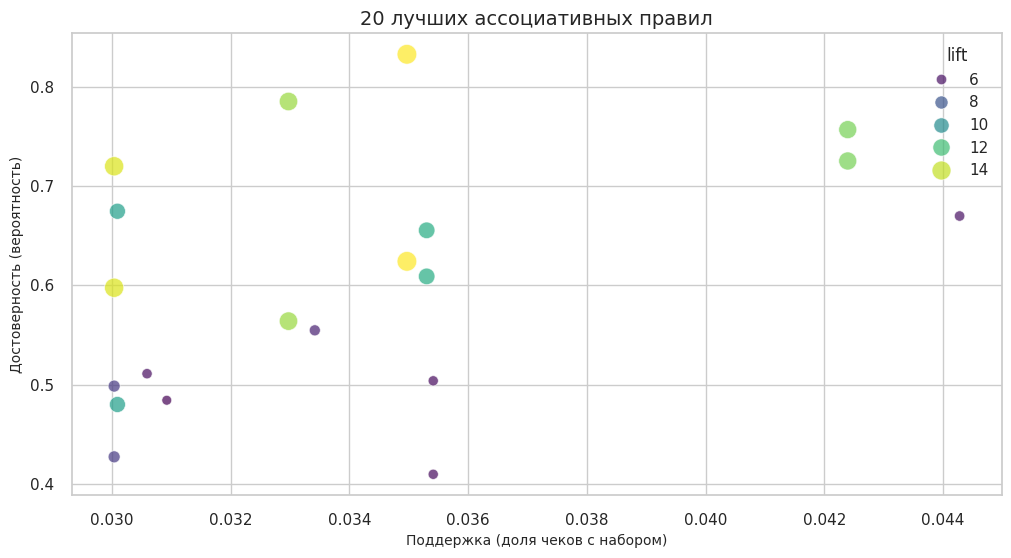

In [36]:
# БЕРЕМ ВСЕ

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

# подготовка данных
print("Загрузка данных...")
try:

    df = pd.read_csv('online_retail.csv', encoding='latin1', parse_dates=['InvoiceDate'])

    # предобработка данных
    df['TotalSum'] = df['Quantity'] * df['UnitPrice']
    df['IsReturn'] = df['InvoiceNo'].astype(str).str.startswith('C')
    purchases = df[(~df['IsReturn']) & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

    q99 = purchases['Quantity'].quantile(0.99)
    purchases = purchases[purchases['Quantity'] <= q99] # добавлена фильтрация

    print(f"Загружено {len(df)} записей, из них {len(purchases)} покупок")
except Exception as e:
    print(f"Ошибка при загрузке данных: {str(e)}")
    raise

# фильтрация данных
print("\nФильтрация данных для ассоциативных правил...")

# берем только чеки с 2+ товарами
multi_item = purchases.groupby('InvoiceNo')['StockCode'].count()
multi_item = multi_item[multi_item >= 2].index
filtered = purchases[purchases['InvoiceNo'].isin(multi_item)]

# # берем топ-100 самых популярных товаров (для скорости)
# top_products = filtered['Description'].value_counts().head(100).index
# filtered = filtered[filtered['Description'].isin(top_products)]

filtered['Description'] = filtered['Description'].str.upper().str.strip()
filtered = filtered[~filtered['Description'].str.contains('POSTAGE|MANUAL|SAMPLE')]


print(f"Для анализа используется {len(filtered)} записей из {filtered['InvoiceNo'].nunique()} чеков")

# подготовка транзакций
print("\nПодготовка транзакций...")
start_time = time.time()

transactions = filtered.groupby('InvoiceNo')['Description'].apply(list).values.tolist()

# создаем бинарную матрицу
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Матрица создана за {time.time()-start_time:.1f} сек. Размер: {basket_df.shape}")

# поиск частых наборов
print("\nПоиск частых наборов товаров...")
start_time = time.time()

frequent_itemsets = apriori(
    basket_df,
    min_support=0.03,  # поддержка 3%
    use_colnames=True,
    max_len=2,         # анализируем только пары
    low_memory=True    # режим экономии памяти
)

print(f"Найдено {len(frequent_itemsets)} наборов за {time.time()-start_time:.1f} сек")

# генерация правил
print("\nГенерация ассоциативных правил...")
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.5  # минимальная сила связи
)

# фильтрация и сортировка
strong_rules = rules[
    (rules['confidence'] > 0.4) &
    (rules['lift'] > 2)
].sort_values('lift', ascending=False)

# визуализация
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=strong_rules.head(20),
    x='support',
    y='confidence',
    size='lift',
    hue='lift',
    palette='viridis',
    sizes=(50, 200),
    alpha=0.7
)
plt.title('20 лучших ассоциативных правил', fontsize=14)
plt.xlabel('Поддержка (доля чеков с набором)', fontsize=10)
plt.ylabel('Достоверность (вероятность)', fontsize=10)
plt.grid(True)
plt.show()

In [37]:
# Оставляем только уникальные пары (A+B = B+A)
def frozen_set_to_sorted_tuple(fs):
    return tuple(sorted(list(fs)))

strong_rules['pair'] = strong_rules.apply(
    lambda row: frozen_set_to_sorted_tuple(row['antecedents'] | row['consequents']),
    axis=1
)

# Убираем дубликаты по уникальной паре
strong_rules_nodup = strong_rules.drop_duplicates('pair').copy()

# Можно сразу сортировать, если нужно
strong_rules_nodup = strong_rules_nodup.sort_values('lift', ascending=False)

if not strong_rules_nodup.empty:
    print("\nТОП-20 АССОЦИАТИВНЫХ ПРАВИЛ (уникальные пары):")
    for i, rule in strong_rules_nodup.head(20).iterrows():
        print(f"\nПРАВИЛО {i+1}:")
        print(f"Если покупают {list(rule['antecedents'])[0]},")
        print(f"то с вероятностью {rule['confidence']:.1%} купят также {list(rule['consequents'])[0]}")
        print(f"Сила связи (lift): {rule['lift']:.1f}")
        print(f"Поддержка: {rule['support']:.2%} чеков содержат этот набор")
else:
    print("Не найдено значимых уникальных ассоциативных правил")


ТОП-20 АССОЦИАТИВНЫХ ПРАВИЛ (уникальные пары):

ПРАВИЛО 5:
Если покупают GREEN REGENCY TEACUP AND SAUCER,
то с вероятностью 62.4% купят также PINK REGENCY TEACUP AND SAUCER
Сила связи (lift): 14.9
Поддержка: 3.50% чеков содержат этот набор

ПРАВИЛО 4:
Если покупают GARDENERS KNEELING PAD CUP OF TEA,
то с вероятностью 72.0% купят также GARDENERS KNEELING PAD KEEP CALM
Сила связи (lift): 14.3
Поддержка: 3.00% чеков содержат этот набор

ПРАВИЛО 34:
Если покупают PINK REGENCY TEACUP AND SAUCER,
то с вероятностью 78.5% купят также ROSES REGENCY TEACUP AND SAUCER
Сила связи (lift): 13.4
Поддержка: 3.30% чеков содержат этот набор

ПРАВИЛО 7:
Если покупают GREEN REGENCY TEACUP AND SAUCER,
то с вероятностью 75.7% купят также ROSES REGENCY TEACUP AND SAUCER
Сила связи (lift): 12.9
Поддержка: 4.24% чеков содержат этот набор

ПРАВИЛО 1:
Если покупают ALARM CLOCK BAKELIKE GREEN,
то с вероятностью 65.5% купят также ALARM CLOCK BAKELIKE RED
Сила связи (lift): 11.3
Поддержка: 3.53% чеков содержат это

# Рекомендации по оптимизации ассортимента, ценообразования и маркетинговых кампаний

---

#### 1. **Оптимизация ассортимента**

На основе анализа выявлены чёткие сочетания товаров, которые покупатели часто приобретают вместе. Рекомендуемые шаги:

**• Создайте готовые наборы:**
  - Чайные пары: объедините **PINK** и **GREEN REGENCY TEACUP** (совместная покупка в 83% случаев)
  - Наборы ланч-боксов: **SPACEBOY** + **DOLLY GIRL** (lift 11.0)
  - Подарочные комплекты сумок **CHARLOTTE** разных цветов

**• Скорректируйте ассортимент:**
  - Увеличьте запасы товаров с высокой частотой совместных покупок
  - Снизьте закупки товаров без явных ассоциативных связей
  - Добавьте недостающие варианты популярных линеек (например, новые цвета чайных пар)

---

#### 2. **Ценовая стратегия**

Анализ показывает возможности для более гибкого ценообразования:

- Введите **специальные цены на наборы** (на 5–10% ниже суммы отдельных товаров)
- Для VIP-клиентов предлагайте **премиальные комплекты** с небольшой наценкой
- Используйте **связные скидки**: "Купи X, получи Y дешевле"
- Проверьте цены на товары с высоким процентом возвратов

---

#### 3. **Маркетинг и продвижение**

Персонализированные подходы для разных сегментов клиентов:

**Для новых покупателей:**
- Акция «Первый набор со скидкой»
- Рекомендации на основе первых покупок

**Для постоянных клиентов:**
- Программа лояльности с бонусами за частые покупки
- Персональные предложения любимых товарных пар

**Для "спящих" клиентов:**
- Специальные условия для возврата
- Предложения популярных наборов с ограниченной скидкой

---

#### 4. **Размещение товаров**

- Расположите связанные товары рядом в торговом зале и/или на сайте
- Создайте специальные разделы «Часто покупают вместе»
- Используйте кросс-мерчендайзинг в промоматериалах

---

#### 5. **Приоритетные действия**

1. Запустить 3–5 тестовых наборов на основе топ-ассоциаций
2. Настроить систему рекомендаций на сайте
3. Разработать программу лояльности для VIP-клиентов
4. Запустить реактивационную кампанию для спящих клиентов

*Эти меры основаны на конкретных данных:*
- Товарные пары с lift (сила связи) > 10
- Сегментация клиентов по RFM-анализу
- Статистика по средним чекам и частоте покупок

**Для контроля эффективности рекомендуем:**
- Еженедельно отслеживать продажи наборов
- Месячный анализ изменения среднего чека
- Тестировать разные варианты скидок

---

## **Бизнес-вывод**

> Анализ ассоциативных правил и сегментации клиентской базы позволил выявить конкретные точки роста для бизнеса.  
> Чётко определены популярные сочетания товаров (например, чайные пары, подарочные ланч-боксы), что открывает возможности для увеличения среднего чека через готовые наборы и персонализированные рекомендации.  
> Гибкая ценовая стратегия — специальные предложения для VIP-клиентов и связные скидки — позволит повысить привлекательность ассортимента и уменьшить возвраты.  
> Для каждой группы покупателей предложены отдельные маркетинговые сценарии:  
> • Привлечение новых клиентов через акционные наборы  
> • Удержание постоянных с помощью бонусов и рекомендаций  
> • Реактивация “спящих” клиентов целевыми промо  
>
> Внедрение системы рекомендаций и промо-наборов, оптимизация выкладки, а также регулярный анализ эффективности этих мер обеспечат устойчивый рост выручки, повышение лояльности и конкурентоспособности компании.

---
